# Document Similarity and Topic Modeling of arXiv Paper Abstracts


## Project Structure

<ol>
    <li> Introduction </li>
    <li> Data </li>
    <li> Text Preprocessing </li>
    <li> Models </li>
    <li> Evaluation </li>
    <li> Potential Improvements </li>
</ol>


## I. Introduction

In this project, I perform exploratory data analysis on Cornell's arXiv database of STEM papers, and use  natural language processing (NLP) and information retrieval (IR) techniques to answer the following questions:

1. Given that we like document $d_i$, what are the documents most similar in language that might interest us?
2. How can we assign a relevant category to a document without knowing arXiv's classification a priori?

#### Requirements

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.bag as db
from dask.distributed import Client
import json

#### Using dask distributed scheduler:

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:61207 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


## II. Data

Before subsetting our data, we can load and perform EDA on the entire dataset using a Dask bag.

In [3]:
papers = db.read_text('arxiv-metadata-oai-snapshot-2020-08-14.json').map(json.loads)

In [4]:
def examine(i):
    ex_i = papers.take(i)[i-1]
    print(json.dumps(ex_i, indent=1))

In [5]:
from ipywidgets import interact

#### Closer Look at Papers in the Dataset:

In [6]:
interact(examine, i=(1, 30));

interactive(children=(IntSlider(value=15, description='i', max=30, min=1), Output()), _dom_classes=('widget-in…

<h4> Some observations for cleaning and analyzing this dataset: </h4>
    
- **Categories**: Some papers are classified as belonging to more than one category. Multiple categories are separated by a single space.
- **Authors Parsed**: A list containing lists of parsed author last name, first name, and typically "". We consider only the (first,last) pairs.



### Category Taxonomy and Top Categories:

In [7]:
from bs4 import BeautifulSoup
import requests

In [8]:
taxonomy_lk = 'https://arxiv.org/category_taxonomy'

In [9]:
text = requests.get(taxonomy_lk).text
soup = BeautifulSoup(text, 'html.parser')
subjects = soup.find_all('h4')[1:]
tax = {}
for subj in subjects:
    abbrev, name = subj.contents
    tax[abbrev.strip()] = name.contents[0].strip('()')
tax = pd.DataFrame(tax.values(), index=tax.keys(), columns=['Subject'])

In [10]:
tax.head()

,Subject
cs.AI,Artificial Intelligence
cs.AR,Hardware Architecture
cs.CC,Computational Complexity
cs.CE,"Computational Engineering, Finance, and Science"
cs.CG,Computational Geometry


### Count

In [11]:
papers.count().compute()

1747307

### Top Categories

In [12]:
ctgry_counts = (papers.map(lambda x: x['categories'].split(' '))
       .flatten()
       .frequencies(sort=True)
       .compute())

In [13]:
cc_df = pd.DataFrame(ctgry_counts, columns=['cat', 'count']).set_index('cat')
subj = tax.join(cc_df).sort_values('count', ascending=False)

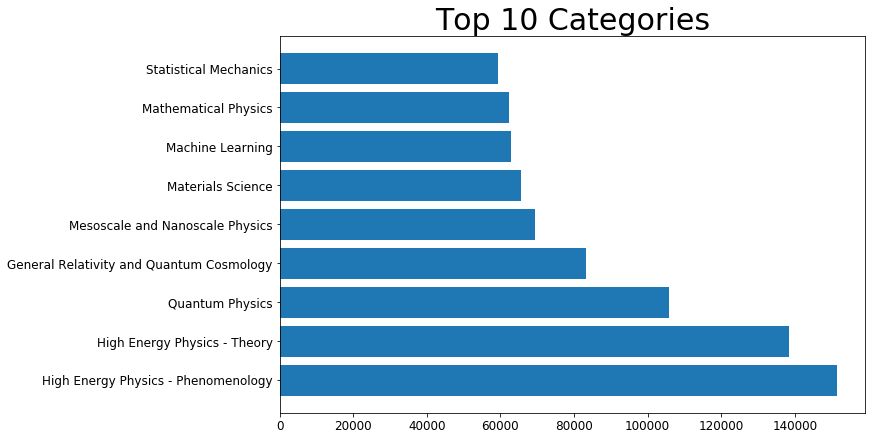

In [14]:
%matplotlib inline
n = 10
fig = plt.figure(figsize=(12,6), constrained_layout=True)
ax = plt.subplot(111)
ax.set_title('Top {} Categories'.format(n), size=30);
ax.barh(subj['Subject'][:n], subj['count'][:n])
ax.tick_params(labelsize=12)

### Top submitters

In [15]:
papers.map(lambda x: x['submitter']).frequencies(sort=True).topk(10, key=1).compute()

[(None, 15191),
 ('EPTCS', 2837),
 ('The CMS Collaboration', 634),
 ('Atlas Publications', 623),
 ('EDA Publishing Association', 391),
 ('Cms Collaboration', 373),
 ('Delfim F. M. Torres', 357),
 ('The ATLAS Collaboration', 319),
 ('Scientific Information Service CERN', 285),
 ('Alice Publications', 269)]

### Top authors (in # of publications)

In [16]:
def author_keys(x):
    return [' '.join(author[:2]).strip() for author in x['authors_parsed']]

In [17]:
(papers.map(lambda x: author_keys(x))
        .flatten()
        .frequencies(sort=True)
        .topk(10, key=1).compute())

[('Zhang Y.', 1616),
 ('Zhang L.', 1096),
 ('Li Y.', 1041),
 ('Wang Y.', 1039),
 ('Wang J.', 1002),
 ('CMS Collaboration', 973),
 ('Gao Y.', 952),
 ('Liu X.', 884),
 ('ATLAS Collaboration', 884),
 ('Yang Z.', 853)]

### Top papers (in # of references)

In [18]:
def paper_keys(x):
    refs = x['journal-ref']
    if refs:
        ref_count = len(refs.split(';'))
        return x['title'], ref_count

In [19]:
(papers.map(lambda x: paper_keys(x))
        .frequencies(sort=True)
        .topk(10, key=1).compute())

[(None, 1069309),
 (('Discussion of: A statistical analysis of multiple temperature proxies:\n  Are reconstructions of surface temperatures over the last 1000 years\n  reliable?',
   1),
  12),
 (('Neutrino Physics', 1), 9),
 (('Discussion of "Least angle regression" by Efron et al', 1), 8),
 (('Discussion of: Brownian distance covariance', 1), 7),
 (('Beyond the Standard Model', 1), 6),
 (('Rejoinder', 1), 6),
 (('Discussion: Latent variable graphical model selection via convex\n  optimization',
   1),
  6),
 (('Discussion: "A significance test for the lasso"', 1), 6),
 (('Discussion of "Breakdown and groups" by P. L. Davies and U. Gather', 1),
  6)]

# III.  Text Preprocessing


We take a subset of papers published after 2018, leaving us with 305,000 papers 

In [20]:
strip = lambda x: {
    'id': x['id'],
    'title': x['title'],
    'category':x['categories'].split(' '),
    'abstract':x['abstract']}
last_version = lambda x: x['versions'][-1]['created']
paper_list = papers.filter(lambda x: int(last_version(x).split(' ')[3]) > 2018).map(strip).compute()
paper_df = pd.DataFrame(paper_list)
paper_df.head()

,id,title,category,abstract
0,0704.1445,Deformed Wigner crystal in a one-dimensional q...,"[cond-mat.str-el, cond-mat.mes-hall]",The spatial Fourier spectrum of the electron...
1,0705.0033,Ergodic Theory: Recurrence,[math.DS],We survey the impact of the Poincar\'e recur...
2,0705.0344,Unifying derived deformation theories,[math.AG],We develop a framework for derived deformati...
3,0705.0825,Einstein's Theory of Gravity in the Presence o...,"[gr-qc, astro-ph, hep-th]",The mysterious `dark energy' needed to expla...
4,0705.2562,Anthropic prediction in a large toy landscape,[hep-th],The successful anthropic prediction of the c...


### Tokenization 

Tokenization is the process of chopping string documents into a set of "symbols" that are representative of a document.

For example: 

"Would you like to eat soup?" --> ["Would", "you", "like", "to", "eat", "soup", "?"]

In [21]:
import re
from gensim.corpora import Dictionary
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import spacy
import en_core_web_sm
from spacy import displacy
nlp = en_core_web_sm.load()
stop_words = set(stopwords.words('english'))

#### Custom Tokenization (handling LaTeX)

In [26]:
def tokenize(txt):
    txt = txt.strip()
    txt = txt.replace('\n', ' ')
    txt = re.sub(r'(?=\$)(.*)(?<=\$)', '', txt) 
    txt = re.sub(r'[0-9]', '', txt)     
    txt = re.sub(r'[^a-zA-Z: ]+', '', txt)
    tokens = txt.lower().split(' ')
    return tokens

In [27]:
tokenize(paper_df['abstract'][3])

['the',
 'mysterious',
 'dark',
 'energy',
 'needed',
 'to',
 'explain',
 'the',
 'current',
 'observations',
 'poses',
 'a',
 'serious',
 'confrontation',
 'between',
 'fundamental',
 'physics',
 'and',
 'cosmology',
 'the',
 'present',
 'crisis',
 'may',
 'be',
 'an',
 'outcome',
 'of',
 'the',
 'so',
 'far',
 'untested',
 'prediction',
 'of',
 'the',
 'general',
 'theory',
 'of',
 'relativity',
 'that',
 'the',
 'pressure',
 'of',
 'the',
 'matter',
 'source',
 'also',
 'gravitates',
 'in',
 'this',
 'view',
 'a',
 'theoretical',
 'analysis',
 'reveals',
 'some',
 'surprising',
 'inconsistencies',
 'and',
 'paradoxes',
 'faced',
 'by',
 'the',
 'energystress',
 'tensor',
 'in',
 'the',
 'presence',
 'of',
 'pressure',
 'which',
 'is',
 'used',
 'to',
 'model',
 'the',
 'matter',
 'content',
 'of',
 'the',
 'universe',
 'including',
 'dark',
 'energy']

### Lemmatization 

In linguistics, the root or canonical form of a word is referred to a <i> lemma </i>. <i> Inflection </i>  is when a lemma is modified through the addition of prefixes or suffixes, changing features such as the word's tense, number, or plurality. 

For example: 

"We went to several stores this afternoon"  --> "We <b>go</b> to several <b>store</b> this afternoon"



### Removal of Stop Words 



In [28]:
def remove_stop(tokens):
    accepted = []
    for w in tokens:
        if (w not in stop_words) and (len(w) > 0):
            accepted.append(w) 
    return accepted

In [29]:
class TokenLemmatizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in tokenize(doc)]

In [51]:
vectorizer = CountVectorizer(tokenizer=TokenLemmatizer(),
                             stop_words='english')
X = vectorizer.fit_transform(paper_df['abstract'][:100000])

In [52]:
# X.toarray()
len(vectorizer.get_feature_names())

168791

In [100]:
paper_df['tok_abstract'] = paper_df['abstract'].apply(lambda x: tokenize(x))
paper_df.head()

,id,title,category,abstract,tok_abstract,word_vecs
0,0704.1445,Deformed Wigner crystal in a one-dimensional q...,"[cond-mat.str-el, cond-mat.mes-hall]",The spatial Fourier spectrum of the electron...,"[spatial, fourier, spectrum, electron, density...","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 3..."
1,0705.0033,Ergodic Theory: Recurrence,[math.DS],We survey the impact of the Poincar\'e recur...,"[survey, impact, poincar'e, recurrence, princi...","[(65, 2), (66, 1), (67, 1), (68, 1), (69, 1), ..."
2,0705.0344,Unifying derived deformation theories,[math.AG],We develop a framework for derived deformati...,"[develop, framework, derived, deformation, the...","[(15, 2), (38, 1), (49, 1), (61, 1), (75, 2), ..."
3,0705.0825,Einstein's Theory of Gravity in the Presence o...,"[gr-qc, astro-ph, hep-th]",The mysterious `dark energy' needed to expla...,"[mysterious, dark, energy', needed, explain, c...","[(38, 1), (61, 1), (75, 1), (110, 1), (111, 1)..."
4,0705.2562,Anthropic prediction in a large toy landscape,[hep-th],The successful anthropic prediction of the c...,"[successful, anthropic, prediction, cosmologic...","[(6, 1), (18, 1), (20, 5), (26, 1), (32, 1), (..."
...,...,...,...,...,...,...
305608,quant-ph/0609011,Decay of discrete state resonantly coupled to ...,"[quant-ph, cond-mat.mes-hall]",A simple quantum mechanical model consisting...,"[simple, quantum, mechanical, model, consistin...","[(6, 1), (16, 1), (25, 2), (26, 1), (27, 1), (..."
305609,quant-ph/0610159,"Are superluminal ""signals"" an acceptable hypot...",[quant-ph],The local hidden variable assumption was rep...,"[local, hidden, variable, assumption, repeated...","[(47, 3), (75, 1), (79, 1), (101, 1), (111, 1)..."
305610,quant-ph/0702160,Discrete-query quantum algorithm for NAND trees,[quant-ph],"Recently, Farhi, Goldstone, and Gutmann gave...","[recently, farhi, goldstone, gutmann, gave, qu...","[(38, 2), (61, 1), (94, 1), (262, 1), (309, 2)..."
305611,quant-ph/9606017,Quantum Mechanics in Terms of Realism,[quant-ph],.We expound an alternative to the Copenhagen...,"[expound, alternative, copenhagen, interpretat...","[(30, 1), (34, 1), (47, 5), (52, 1), (67, 1), ..."


In [105]:
%%time
paper_df['tok_abstract'] = paper_df['tok_abstract'].apply(lambda x: lemmatize(x))

CPU times: user 1h 46min 40s, sys: 9min 37s, total: 1h 56min 18s
Wall time: 17h 7min 50s


# Vectorization

In [63]:
dictionary = Dictionary(paper_df['tok_abstract'])
dictionary.filter_extremes(no_below=20, no_above=0.5)
?dictionary

Type:           Dictionary
String form:    Dictionary(21797 unique tokens: ['absent', 'affect', 'allow', 'base', 'behavior']...)
Length:         21797
File:           ~/anaconda3/lib/python3.7/site-packages/gensim/corpora/dictionary.py
Docstring:     
Dictionary encapsulates the mapping between normalized words and their integer ids.

Notable instance attributes:

Attributes
----------
token2id : dict of (str, int)
    token -> tokenId.
id2token : dict of (int, str)
    Reverse mapping for token2id, initialized in a lazy manner to save memory (not created until needed).
cfs : dict of (int, int)
    Collection frequencies: token_id -> how many instances of this token are contained in the documents.
dfs : dict of (int, int)
    Document frequencies: token_id -> how many documents contain this token.
num_docs : int
    Number of documents processed.
num_pos : int
    Total number of corpus positions (number of processed words).
num_nnz : int
    Total number of non-zeroes in the BOW matri

In [64]:
len(dictionary)

21797

In [65]:
%%time
paper_df['word_vecs'] = paper_df['tok_abstract'].apply(lambda x: dictionary.doc2bow(x))
paper_df.word_vecs

CPU times: user 27.2 s, sys: 9.49 s, total: 36.7 s
Wall time: 39.6 s


0         [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 3...
1         [(65, 2), (66, 1), (67, 1), (68, 1), (69, 1), ...
2         [(15, 2), (38, 1), (49, 1), (61, 1), (75, 2), ...
3         [(38, 1), (61, 1), (75, 1), (110, 1), (111, 1)...
4         [(6, 1), (18, 1), (20, 5), (26, 1), (32, 1), (...
                                ...                        
305608    [(6, 1), (16, 1), (25, 2), (26, 1), (27, 1), (...
305609    [(47, 3), (75, 1), (79, 1), (101, 1), (111, 1)...
305610    [(38, 2), (61, 1), (94, 1), (262, 1), (309, 2)...
305611    [(30, 1), (34, 1), (47, 5), (52, 1), (67, 1), ...
305612    [(2, 1), (49, 1), (86, 1), (94, 1), (110, 1), ...
Name: word_vecs, Length: 305613, dtype: object

# Models

In [66]:
from gensim.models import LdaModel
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [69]:
%%time
num_topics = 25
chunksize = 20000
passes = 20
iterations = 400
eval_every = None

temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=paper_df['word_vecs'][:100000],
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

2020-09-02 15:19:02,536 : INFO : using autotuned alpha, starting with [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]
2020-09-02 15:19:02,545 : INFO : using serial LDA version on this node
2020-09-02 15:19:02,752 : INFO : running online (multi-pass) LDA training, 50 topics, 20 passes over the supplied corpus of 100000 documents, updating model once every 10000 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
2020-09-02 15:19:02,771 : INFO : PROGRESS: pass 0, at document #10000/100000
2020-09-02 15:19:41,887 : INFO : optimized alpha [0.018264687, 0.018669872, 0.018732792, 0.018740628, 0.018344222, 0.018500129, 0.018553631, 0.018478205, 0.018345712, 0.018347308, 0.018730853, 0.0182

CPU times: user 1h 1min 7s, sys: 1min 25s, total: 1h 2min 33s
Wall time: 43min 25s


In [81]:
pyLDAvis.enable_notebook()

In [84]:
paper_df[:100000]

,id,title,category,abstract,tok_abstract,word_vecs
0,0704.1445,Deformed Wigner crystal in a one-dimensional q...,"[cond-mat.str-el, cond-mat.mes-hall]",The spatial Fourier spectrum of the electron...,"[spatial, fourier, spectrum, electron, density...","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 3..."
1,0705.0033,Ergodic Theory: Recurrence,[math.DS],We survey the impact of the Poincar\'e recur...,"[survey, impact, poincar'e, recurrence, princi...","[(65, 2), (66, 1), (67, 1), (68, 1), (69, 1), ..."
2,0705.0344,Unifying derived deformation theories,[math.AG],We develop a framework for derived deformati...,"[develop, framework, derive, deformation, theo...","[(15, 2), (38, 1), (49, 1), (61, 1), (75, 2), ..."
3,0705.0825,Einstein's Theory of Gravity in the Presence o...,"[gr-qc, astro-ph, hep-th]",The mysterious `dark energy' needed to expla...,"[mysterious, dark, energy, ', need, explain, c...","[(38, 1), (61, 1), (75, 1), (110, 1), (111, 1)..."
4,0705.2562,Anthropic prediction in a large toy landscape,[hep-th],The successful anthropic prediction of the c...,"[successful, anthropic, prediction, cosmologic...","[(6, 1), (18, 1), (20, 5), (26, 1), (32, 1), (..."
...,...,...,...,...,...,...
99995,1905.09259,Networks and Hierarchies: How Amorphous Materi...,"[cond-mat.soft, cond-mat.dis-nn, cond-mat.mtrl...",We consider the slow and athermal deformatio...,"[consider, slow, athermal, deformation, amorph...","[(4, 1), (15, 2), (41, 1), (47, 1), (49, 1), (..."
99996,1905.09260,A wider look at the gravitational-wave transie...,[gr-qc],"In this paper, we investigate the morphology...","[paper, investigate, morphology, event, gwtc, ...","[(3, 1), (17, 1), (24, 2), (32, 1), (37, 3), (..."
99997,1905.09261,Epitaxial Graphene Intercalation: A Route to G...,[cond-mat.mtrl-sci],Intercalation of atomic species through epit...,"[intercalation, atomic, species, epitaxial, gr...","[(3, 2), (9, 1), (26, 1), (28, 1), (32, 1), (3..."
99998,1905.09262,Phase-coherent caloritronics with ordinary and...,"[cond-mat.mes-hall, cond-mat.supr-con]",We provide a brief and comprehensive overvie...,"[provide, brief, comprehensive, overview, rece...","[(3, 2), (41, 1), (49, 1), (67, 1), (90, 1), (..."


In [86]:
pyLDAvis.gensim.prepare(model, paper_df['word_vecs'][:100000], dictionary)

2020-09-05 19:28:10,466 : INFO : NumExpr defaulting to 4 threads.


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
27     0.141163  0.075150       1        1  5.425991
47     0.139406  0.059611       2        1  4.373014
1      0.176265  0.013879       3        1  4.116355
37     0.112846 -0.074976       4        1  4.112230
49     0.129366  0.083629       5        1  4.002070
17     0.145637 -0.034867       6        1  3.870605
18     0.088420 -0.187387       7        1  3.399373
19     0.092278 -0.234784       8        1  3.192708
16     0.157437 -0.025914       9        1  3.171690
25     0.120430  0.114731      10        1  3.047875
31     0.106744  0.129555      11        1  3.001279
7      0.066260  0.107136      12        1  2.821533
46     0.102540 -0.134706      13        1  2.808296
44     0.105869 -0.009185      14        1  2.801867
33     0.039536 -0.258002      15        1  2.568615
10     0.063184  0.048551      16        1  2.438393
45     0.074112  0.021265      17        1  2.399567
9      0.035222 -0.262108      18        1  2.391317
21     0.081821  0.102962      19        1  2.303787
15     0.081269  0.141694      20        1  2.239532
36     0.104741  0.069301      21        1  2.095328
41     0.055258 -0.116792      22        1  1.971656
28     0.010461  0.120138      23        1  1.960464
0      0.037370 -0.218782      24        1  1.803727
23     0.051365  0.109184      25        1  1.730091
22     0.077256  0.016563      26        1  1.717052
12     0.031658  0.123837      27        1  1.666697
6      0.056296  0.163287      28        1  1.648438
42     0.103305  0.104619      29        1  1.538905
20    -0.012649 -0.095685      30        1  1.436204
32    -0.222636 -0.009125      31        1  1.324340
40    -0.010594 -0.133924      32        1  1.318081
11     0.056904  0.043295      33        1  1.309960
5      0.005709  0.117177      34        1  1.255672
30    -0.000192 -0.137302      35        1  1.223796
26    -0.035497  0.007248      36        1  1.211190
43     0.012673 -0.003936      37        1  1.183350
29    -0.034997  0.050804      38        1  1.163880
38    -0.159262 -0.069005      39        1  1.067662
3     -0.129638  0.068755      40        1  0.921469
14    -0.033479 -0.099259      41        1  0.862188
39    -0.159775  0.040094      42        1  0.830097
35    -0.065939  0.080848      43        1  0.765472
13    -0.223602 -0.082891      44        1  0.715277
2     -0.218249  0.057109      45        1  0.554458
48    -0.260040  0.044528      46        1  0.500929
4     -0.261871  0.034342      47        1  0.499937
24    -0.278568  0.022192      48        1  0.415865
8     -0.272431  0.000901      49        1  0.414343
34    -0.283385  0.016247      50        1  0.407368, topic_info=             Term          Freq         Total Category  logprob  loglift
57         system  42463.000000  42463.000000  Default  30.0000  30.0000
807             }  23927.000000  23927.000000  Default  29.0000  29.0000
37         method  44043.000000  44043.000000  Default  28.0000  28.0000
309       quantum  22724.000000  22724.000000  Default  27.0000  27.0000
30       function  28611.000000  28611.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
2238    violation    561.111450   1112.024902  Topic50  -4.1572   4.8192
1177  equilibrium    884.737915   3540.745117  Topic50  -3.7018   4.1164
444     subsystem    332.642120    594.736450  Topic50  -4.6801   4.9222
5266    indicator    354.465698    749.495605  Topic50  -4.6165   4.7544
2992    strategic    202.624863    264.685608  Topic50  -5.1758   5.2360

[3304 rows x 6 columns], token_table=       Topic      Freq Term
term                       
451        4  0.999929    "
6461      32  0.994631    #
3349       1  0.284446    %
3349       2  0.085125    %
3349       5  0.000110    %
...      ...       ...  ...
351       23  0.831809    ~
351       27  0.014185    ~
351    

### Need to improve tokenization to exclude:

- {
- }
- "
- ' % ~ ?
- ; : 's